In [7]:
import pandas as pd
df = pd.read_csv("hmeq-1.csv")
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import statsmodels
import re

In [10]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

In [11]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

In [12]:
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import traceback
import string

In [13]:
df[['BAD']].value_counts(normalize=True)

BAD
0      0.800503
1      0.199497
Name: proportion, dtype: float64

In [14]:
df.isnull().sum().sort_values(ascending=False)

DEBTINC    1267
DEROG       708
DELINQ      580
MORTDUE     518
YOJ         515
NINQ        510
CLAGE       308
JOB         279
REASON      252
CLNO        222
VALUE       112
LOAN          0
BAD           0
dtype: int64

In [15]:
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
print(missing_percent)

DEBTINC    21.258389
DEROG      11.879195
DELINQ      9.731544
MORTDUE     8.691275
YOJ         8.640940
NINQ        8.557047
CLAGE       5.167785
JOB         4.681208
REASON      4.228188
CLNO        3.724832
VALUE       1.879195
LOAN        0.000000
BAD         0.000000
dtype: float64


In [16]:
categorical_features = [col for col in df.columns if df[col].dtype == 'object']
numerical_features = [col for col in df.columns if df[col].dtype != 'object']

print('Number of categorical features:', len(categorical_features))
print('Number of numerical features:', len(numerical_features))

Number of categorical features: 2
Number of numerical features: 11


In [17]:
# Đếm tần số của từng giá trị trong mỗi feature theo BAD
for feature in categorical_features:
    print(f"\nTần số của {feature} theo BAD:")
    freq_table = pd.crosstab(df[feature], df['BAD'], dropna=False)  # Giữ giá trị NaN nếu có
    print(freq_table)


Tần số của REASON theo BAD:
BAD         0    1
REASON            
DebtCon  3183  745
HomeImp  1384  396
NaN       204   48

Tần số của JOB theo BAD:
BAD         0    1
JOB               
Mgr       588  179
Office    823  125
Other    1834  554
ProfExe  1064  212
Sales      71   38
Self      135   58
NaN       256   23


In [18]:
df['REASON'] = df['REASON'].fillna('DebtCon')
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,DebtCon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [19]:
df.loc[(df['JOB'].isnull()) & (df['BAD'] == 0), 'JOB'] = 'Office'
df.loc[(df['JOB'].isnull()) & (df['BAD'] == 1), 'JOB'] = 'Other'

for feature in categorical_features:
    print(f"\nTần số của {feature} theo BAD:")
    freq_table = pd.crosstab(df[feature], df['BAD'], dropna=False)  # Giữ giá trị NaN nếu có
    print(freq_table)


Tần số của REASON theo BAD:
BAD         0    1
REASON            
DebtCon  3387  793
HomeImp  1384  396

Tần số của JOB theo BAD:
BAD         0    1
JOB               
Mgr       588  179
Office   1079  125
Other    1834  577
ProfExe  1064  212
Sales      71   38
Self      135   58


In [20]:
median_value_bad_0 = df[df['BAD'] == 0]['VALUE'].median()
median_value_bad_1 = df[df['BAD'] == 1]['VALUE'].median()

# Điền giá trị thiếu theo BAD
df.loc[(df['VALUE'].isna()) & (df['BAD'] == 0), 'VALUE'] = median_value_bad_0
df.loc[(df['VALUE'].isna()) & (df['BAD'] == 1), 'VALUE'] = median_value_bad_1

In [21]:
cols_median_by_bad = ['CLNO', 'YOJ', 'CLAGE', 'NINQ', 'DELINQ', 'DEROG']
for col in cols_median_by_bad:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    median_bad_0 = df[df['BAD'] == 0][col].median()
    median_bad_1 = df[df['BAD'] == 1][col].median()
    df.loc[(df[col].isna()) & (df['BAD'] == 0), col] = median_bad_0
    df.loc[(df[col].isna()) & (df['BAD'] == 1), col] = median_bad_1

In [22]:
features_mortdue = ['CLNO', 'VALUE', 'LOAN', 'BAD', 'MORTDUE']
df_mortdue_impute = df[features_mortdue].copy()

# Đảm bảo chỉ số đồng bộ
df_mortdue_impute.index = df.index

# Xử lý giá trị không phải số
for col in features_mortdue:
    df_mortdue_impute[col] = pd.to_numeric(df_mortdue_impute[col], errors='coerce')

# Kiểm tra NaN trước khi chạy KNN
print("\nSố lượng NaN trong các feature trước khi điền MORTDUE:")
print(df_mortdue_impute.isna().sum())

# Áp dụng KNN Imputer
imputer_mortdue = KNNImputer(n_neighbors=5)
df_mortdue_filled = imputer_mortdue.fit_transform(df_mortdue_impute)

# Chuyển đổi ngược về DataFrame
df_mortdue_filled = pd.DataFrame(df_mortdue_filled, columns=features_mortdue, index=df.index)

# Gán lại giá trị MORTDUE
df['MORTDUE'] = df_mortdue_filled['MORTDUE']

# 4. Kiểm tra số lượng giá trị thiếu sau khi điền
print("\nSố lượng giá trị thiếu trong MORTDUE sau khi điền:", df['MORTDUE'].isna().sum())


Số lượng NaN trong các feature trước khi điền MORTDUE:
CLNO         0
VALUE        0
LOAN         0
BAD          0
MORTDUE    518
dtype: int64

Số lượng giá trị thiếu trong MORTDUE sau khi điền: 0


In [23]:
# 3. Điền DEBTINC bằng KNN Imputation
features_debtinc = ['CLNO', 'MORTDUE', 'NINQ', 'LOAN', 'VALUE', 'BAD', 'DEBTINC']
df_debtinc_impute = df[features_debtinc].copy()

# Đảm bảo chỉ số đồng bộ
df_debtinc_impute.index = df.index

# Xử lý giá trị không phải số
for col in features_debtinc:
    df_debtinc_impute[col] = pd.to_numeric(df_debtinc_impute[col], errors='coerce')

# Kiểm tra NaN trước khi chạy KNN
print("\nSố lượng NaN trong các feature trước khi điền DEBTINC:")
print(df_debtinc_impute.isna().sum())

# Áp dụng KNN Imputer
imputer_debtinc = KNNImputer(n_neighbors=5)
df_debtinc_filled = imputer_debtinc.fit_transform(df_debtinc_impute)

# Chuyển đổi ngược về DataFrame
df_debtinc_filled = pd.DataFrame(df_debtinc_filled, columns=features_debtinc, index=df.index)

# Gán lại giá trị DEBTINC
df['DEBTINC'] = df_debtinc_filled['DEBTINC']

# 4. Kiểm tra số lượng giá trị thiếu sau khi điền
print("\nSố lượng giá trị thiếu trong DEBTINC sau khi điền:", df['DEBTINC'].isna().sum())


Số lượng NaN trong các feature trước khi điền DEBTINC:
CLNO          0
MORTDUE       0
NINQ          0
LOAN          0
VALUE         0
BAD           0
DEBTINC    1267
dtype: int64

Số lượng giá trị thiếu trong DEBTINC sau khi điền: 0


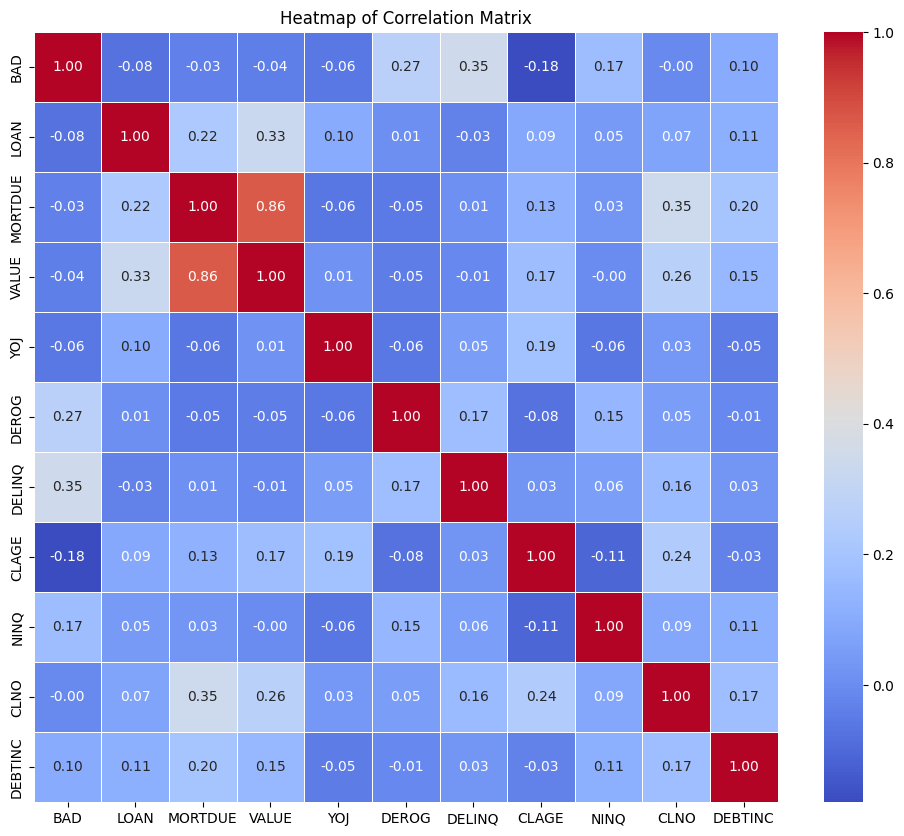

In [24]:
# Tính ma trận tương quan
# Chọn chỉ các cột số để tính toán ma trận tương quan
correlation_matrix = df[numerical_features].corr()

# Vẽ heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [25]:
# Lọc toàn bộ outlier theo IQR cho các biến số
def remove_outliers_iqr(df_input, columns):
    df_temp = df_input.copy()
    for col in columns:
        Q1 = df_temp[col].quantile(0.25)
        Q3 = df_temp[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_temp = df_temp[(df_temp[col] >= lower_bound) & (df_temp[col] <= upper_bound)]
    return df

# Lấy danh sách các cột số (trừ cột target)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('BAD')

# Áp dụng lọc outlier
df_clean = remove_outliers_iqr(df, num_cols)

In [26]:
import pandas as pd
import numpy as np

def calculate_woe_iv(df, feature, target, bins=10):
    # Chia bin nếu là continuous feature
    if pd.api.types.is_numeric_dtype(df[feature]):
        df['bucket'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    else:
        df['bucket'] = df[feature]

    # Tạo bảng tổng hợp
    woe_df = df.groupby('bucket').agg({target: ['sum', 'count']})
    woe_df.columns = ['Bad', 'Total']
    woe_df['Good'] = woe_df['Total'] - woe_df['Bad']

    # Tính tỷ lệ % Good và % Bad
    woe_df['% Good'] = woe_df['Good'] / woe_df['Good'].sum()
    woe_df['% Bad'] = woe_df['Bad'] / woe_df['Bad'].sum()

    # Tính WOE và IV
    woe_df['WOE'] = np.log(woe_df['% Good'] / woe_df['% Bad'])
    woe_df['IV'] = (woe_df['% Good'] - woe_df['% Bad']) * woe_df['WOE']

    # Tổng IV cho toàn bộ feature
    iv = woe_df['IV'].sum()

    return iv, woe_df[['Bad', 'Good', 'Total', '% Good', '% Bad', 'WOE', 'IV']]

# Danh sách các cột cần tính IV
features = ["DEBTINC", "MORTDUE", "VALUE", "DEROG", "CLAGE", "NINQ", "DELINQ", "YOJ", "CLNO", "REASON", "JOB"]
iv_scores = {}

# Tính IV cho từng feature và lưu kết quả
for feature in features:
    # Check if feature exists in the dataframe before calculating IV
    if feature in df.columns:
        iv, detail = calculate_woe_iv(df, feature, "BAD")
        # Only store and print if IV calculation was successful (iv is not 0 and detail is not None)
        if detail is not None:
            iv_scores[feature] = iv
            print(f"Feature: {feature}, IV: {iv:.4f}")
        else:
            print(f"Feature: {feature}, IV cannot be calculated (all target values are the same or missing).")
    else:
        print(f"Feature: {feature} not found in DataFrame.")


# Sắp xếp các feature theo IV từ cao xuống thấp
# Convert the dictionary to a list of tuples for sorting
iv_sorted = sorted(iv_scores.items(), key=lambda x: x[1], reverse=True)

# In kết quả
print("\nSorted IV scores:") # This line is corrected
for feature, iv in iv_sorted:
    print(f"{feature}: {iv:.4f}")

C:\Users\Admin\AppData\Local\Temp\ipykernel_4180\1001411779.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_df = df.groupby('bucket').agg({target: ['sum', 'count']})
C:\Users\Admin\AppData\Local\Temp\ipykernel_4180\1001411779.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_df = df.groupby('bucket').agg({target: ['sum', 'count']})


Feature: DEBTINC, IV: 0.1120
Feature: MORTDUE, IV: 0.0429


C:\Users\Admin\AppData\Local\Temp\ipykernel_4180\1001411779.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_df = df.groupby('bucket').agg({target: ['sum', 'count']})


Feature: VALUE, IV: 0.1722


C:\Users\Admin\AppData\Local\Temp\ipykernel_4180\1001411779.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_df = df.groupby('bucket').agg({target: ['sum', 'count']})


Feature: DEROG, IV: 0.2554
Feature: CLAGE, IV: 0.3399


C:\Users\Admin\AppData\Local\Temp\ipykernel_4180\1001411779.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_df = df.groupby('bucket').agg({target: ['sum', 'count']})
C:\Users\Admin\AppData\Local\Temp\ipykernel_4180\1001411779.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_df = df.groupby('bucket').agg({target: ['sum', 'count']})


Feature: NINQ, IV: 0.1639


C:\Users\Admin\AppData\Local\Temp\ipykernel_4180\1001411779.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_df = df.groupby('bucket').agg({target: ['sum', 'count']})


Feature: DELINQ, IV: 0.4107


C:\Users\Admin\AppData\Local\Temp\ipykernel_4180\1001411779.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_df = df.groupby('bucket').agg({target: ['sum', 'count']})
C:\Users\Admin\AppData\Local\Temp\ipykernel_4180\1001411779.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  woe_df = df.groupby('bucket').agg({target: ['sum', 'count']})


Feature: YOJ, IV: 0.2083
Feature: CLNO, IV: 0.0585
Feature: REASON, IV: 0.0086
Feature: JOB, IV: 0.1559

Sorted IV scores:
DELINQ: 0.4107
CLAGE: 0.3399
DEROG: 0.2554
YOJ: 0.2083
VALUE: 0.1722
NINQ: 0.1639
JOB: 0.1559
DEBTINC: 0.1120
CLNO: 0.0585
MORTDUE: 0.0429
REASON: 0.0086


In [27]:
# Xóa cột 'REASON'
df = df.drop('REASON', axis=1)
df = df.drop('bucket', axis=1)

# Kiểm tra lại các cột sau khi xóa
print("Các cột sau khi xóa 'REASON':")
print(df.columns)

Các cột sau khi xóa 'REASON':
Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'JOB', 'YOJ', 'DEROG', 'DELINQ',
       'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')


In [28]:
# Điền missing value trước khi encode
df["JOB"] = df["JOB"].fillna("Unknown")

# Thực hiện One-Hot Encoding
df = pd.get_dummies(df, columns=["JOB"], drop_first=True)

# Kiểm tra kết quả
print(df.head())

   BAD  LOAN  MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
0    1  1100  25860.0   39025.0  10.5    0.0     0.0   94.366667   1.0   9.0   
1    1  1300  70053.0   68400.0   7.0    0.0     2.0  121.833333   0.0  14.0   
2    1  1500  13500.0   16700.0   4.0    0.0     0.0  149.466667   1.0  10.0   
3    1  1500  26759.4   82000.0   6.0    0.0     0.0  132.866667   1.0  20.0   
4    0  1700  97800.0  112000.0   3.0    0.0     0.0   93.333333   0.0  14.0   

     DEBTINC  JOB_Office  JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
0  36.039356       False       True        False      False     False  
1  40.695851       False       True        False      False     False  
2  36.196050       False       True        False      False     False  
3  15.787198       False       True        False      False     False  
4  34.370509        True      False        False      False     False  


In [29]:
print(df.filter(like="JOB_").sum())

JOB_Office     1204
JOB_Other      2411
JOB_ProfExe    1276
JOB_Sales       109
JOB_Self        193
dtype: int64


In [30]:
# Chuyển đổi tất cả các cột JOB_* từ boolean về integer
job_cols = df.filter(like="JOB_").columns
df[job_cols] = df[job_cols].astype(int)
# Kiểm tra lại
print(df[job_cols].head())

   JOB_Office  JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self
0           0          1            0          0         0
1           0          1            0          0         0
2           0          1            0          0         0
3           0          1            0          0         0
4           1          0            0          0         0


In [31]:
df

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,36.039356,0,1,0,0,0
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,40.695851,0,1,0,0,0
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,36.196050,0,1,0,0,0
3,1,1500,26759.4,82000.0,6.0,0.0,0.0,132.866667,1.0,20.0,15.787198,0,1,0,0,0
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,34.370509,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0,1,0,0,0
5956,0,89000,54576.0,92937.0,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0,1,0,0,0
5957,0,89200,54045.0,92924.0,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0,1,0,0,0
5958,0,89800,50370.0,91861.0,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0,1,0,0,0


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [33]:
X = df.drop(columns=["BAD"])
y = df["BAD"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 4768, Test size: 1192


In [34]:
# Kiểm tra kiểu dữ liệu của các cột
print(X_train.dtypes)

LOAN             int64
MORTDUE        float64
VALUE          float64
YOJ            float64
DEROG          float64
DELINQ         float64
CLAGE          float64
NINQ           float64
CLNO           float64
DEBTINC        float64
JOB_Office       int64
JOB_Other        int64
JOB_ProfExe      int64
JOB_Sales        int64
JOB_Self         int64
dtype: object


In [35]:
scaler = MinMaxScaler()

cols = X_train.columns
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

In [36]:
sm = SMOTE(random_state=42)
X_train,y_train = sm.fit_resample(X_train,y_train)
print("Dimension of X_train_sm Shape:", X_train.shape)
print("Dimension of y_train_sm Shape:", y_train.shape)

Dimension of X_train_sm Shape: (7634, 15)
Dimension of y_train_sm Shape: (7634,)


1. Logistic Regression

In [37]:
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.9
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,100
,multi_class,'deprecated'


In [38]:
def evaluation(model):
    y_test_pred = model.predict(X_test)

    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    print("Accuracy of TEST data: {:.2f}%".format(100 * accuracy_score(y_test, y_test_pred)))
    print("F1 Score of TEST data: {:.2f}%".format(100 * f1_score(y_test, y_test_pred, average="macro")))
    print("Recall of TEST data: {:.2f}%".format(100 * recall_score(y_test, y_test_pred, average="macro")))
    print("="*50)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("RMSE: ", rmse)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_test_pred, average=None)
    print("ROC AUC score: ", roc_auc)

evaluation(lr)

[[740 214]
 [ 91 147]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       954
           1       0.41      0.62      0.49       238

    accuracy                           0.74      1192
   macro avg       0.65      0.70      0.66      1192
weighted avg       0.79      0.74      0.76      1192

Accuracy of TEST data: 74.41%
F1 Score of TEST data: 66.00%
Recall of TEST data: 69.67%
RMSE:  0.5058383963495421
ROC AUC score:  0.6966642002713035


2. Random Forest

In [39]:
regr_rfr = RandomForestClassifier(random_state=42, oob_score=True)
regr_rfr.fit(X_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [40]:
evaluation(regr_rfr)

[[933  21]
 [ 61 177]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       954
           1       0.89      0.74      0.81       238

    accuracy                           0.93      1192
   macro avg       0.92      0.86      0.88      1192
weighted avg       0.93      0.93      0.93      1192

Accuracy of TEST data: 93.12%
F1 Score of TEST data: 88.49%
Recall of TEST data: 86.08%
RMSE:  0.26228218831770644
ROC AUC score:  0.8608424501876222


In [41]:
!pip install optuna

In [42]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, recall_score, classification_report, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# === Bước 1: Hàm Recall tùy chỉnh cho lớp 1 (BAD) ===
def custom_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)

recall_scorer = make_scorer(custom_recall_score)

# === Bước 2: Hàm objective cho Optuna ===
def objective(trial):
    # Tập siêu tham số cho RandomForest
    params = {
        "classifier__n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "classifier__max_depth": trial.suggest_int("max_depth", 2, 22),
        "classifier__min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "classifier__min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "classifier__max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "classifier__bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "classifier__ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.1)
    }

    # Tạo pipeline với SMOTE và RandomForestClassifier
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    pipeline.set_params(**params)

    # Tính điểm Recall trung bình từ 5-fold cross-validation
    recall = cross_val_score(pipeline, X_train, y_train, scoring=recall_scorer, cv=5).mean()
    return recall

# === Bước 3: Tạo và chạy Optuna study ===
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, timeout=600)

# === Bước 4: In kết quả tốt nhất ===
print("✅ Best Recall (train CV):", study.best_value)
print("📌 Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# === Bước 5: Huấn luyện lại mô hình với các siêu tham số tốt nhất ===
best_params = {key.replace("classifier__", ""): value for key, value in study.best_params.items()}
best_rf_model = RandomForestClassifier(**best_params, random_state=42)

# Tạo pipeline cho huấn luyện cuối cùng
final_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_rf_model)
])

# Huấn luyện mô hình trên toàn bộ tập train
final_pipeline.fit(X_train, y_train)

# === Bước 6: Hàm evaluation tùy chỉnh ===
def evaluation(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    y_test_pred = model.predict(X_test)

    # Dự đoán xác suất cho ROC AUC
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None


    # In kết quả cho tập test
    print("\n==================================================")
    print("Evaluation for Test Data")
    print("==================================================")
    print(classification_report(y_test, y_test_pred))
    print(f"Accuracy of TEST data: {100 * np.mean(y_test_pred == y_test):.2f}")
    print(f"Recall of TEST data (class 1): {100 * recall_score(y_test, y_test_pred, pos_label=1):.2f}")

    # ROC AUC score (nếu có xác suất)
    if y_test_proba is not None:
        print(f"ROC AUC score: {roc_auc_score(y_test, y_test_proba):.4f}")

    # RMSE (dựa trên xác suất, nếu có)
    if y_test_proba is not None:
        rmse = np.sqrt(np.mean((y_test - y_test_proba) ** 2))
        print(f"RMSE: {rmse:.4f}")

# === Bước 7: Đánh giá mô hình tốt nhất ===
print("\n==================================================")
print("Evaluation for the best Random Forest Model")
evaluation(final_pipeline)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-09-09 11:22:20,301] A new study created in memory with name: no-name-25238b9f-c1f1-4a67-8f35-7fc5cfb3ea0a
[I 2025-09-09 11:28:23,347] Trial 0 finished with value: 0.5315618288239452 and parameters: {'n_estimators': 143, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': None, 'bootstrap': False, 'ccp_alpha': 0.07865983631779914}. Best is trial 0 with value: 0.5315618288239452.
[I 2025-09-09 11:29:53,708] Trial 1 finished with value: 0.5315618288239452 and parameters: {'n_estimators': 276, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'bootstrap': False, 'ccp_alpha': 0.059646344437962}. Best is trial 0 with value: 0.5315618288239452

✅ Best Recall (train CV): 0.5315618288239452
📌 Best hyperparameters:
  n_estimators: 143
  max_depth: 17
  min_samples_split: 13
  min_samples_leaf: 15
  max_features: None
  bootstrap: False
  ccp_alpha: 0.07865983631779914

Evaluation for the best Random Forest Model

Evaluation for Test Data
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       954
           1       0.45      0.45      0.45       238

    accuracy                           0.78      1192
   macro avg       0.66      0.66      0.66      1192
weighted avg       0.78      0.78      0.78      1192

Accuracy of TEST data: 78.10
Recall of TEST data (class 1): 44.54
ROC AUC score: 0.6551
RMSE: 0.4517


3. Decision Tree

In [43]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [44]:
evaluation(tree_model)


Evaluation for Test Data
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       954
           1       0.72      0.73      0.73       238

    accuracy                           0.89      1192
   macro avg       0.83      0.83      0.83      1192
weighted avg       0.89      0.89      0.89      1192

Accuracy of TEST data: 89.01
Recall of TEST data (class 1): 72.69
ROC AUC score: 0.8289
RMSE: 0.3315


In [45]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, recall_score, classification_report, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import numpy as np
 
# Giả định X_train, y_train, X_test, y_test đã được định nghĩa
# Nếu chưa có, bạn cần thêm đoạn mã chia dữ liệu:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
# === Bước 1: Hàm Recall tùy chỉnh cho lớp 1 (BAD) ===
def custom_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)
 
recall_scorer = make_scorer(custom_recall_score)
 
# === Bước 2: Hàm objective cho Optuna ===
def objective(trial):
    # Tập siêu tham số cần tìm (giới hạn max_depth để giảm overfitting)
    params = {
        "classifier__criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "classifier__max_depth": trial.suggest_int("max_depth", 2, 22),  # Giảm từ 40 xuống 20
        "classifier__min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "classifier__min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "classifier__max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "classifier__ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.1)  # Thêm ccp_alpha
    }
 
    # Tạo pipeline với SMOTE và DecisionTreeClassifier
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])
    pipeline.set_params(**params)
 
    # Tính điểm Recall trung bình từ 5-fold cross-validation
    recall = cross_val_score(pipeline, X_train, y_train, scoring=recall_scorer, cv=5).mean()
    return recall
 
# === Bước 3: Tạo và chạy Optuna study ===
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, timeout=600)  # Giảm n_trials từ 20000 xuống 100
 
# === Bước 4: In kết quả tốt nhất ===
print("✅ Best Recall (train CV):", study.best_value)
print("📌 Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
 
# === Bước 5: Huấn luyện lại mô hình với các siêu tham số tốt nhất ===
best_params = {key.replace("classifier__", ""): value for key, value in study.best_params.items()}
best_tree_model = DecisionTreeClassifier(**best_params, random_state=42)
 
# Tạo pipeline cho huấn luyện cuối cùng
final_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_tree_model)
])
 
# Huấn luyện mô hình trên toàn bộ tập train
final_pipeline.fit(X_train, y_train)
 
# === Bước 6: Hàm evaluation tùy chỉnh ===
def evaluation(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    # Dự đoán trên tập train và test
    y_test_pred = model.predict(X_test)
 
    # Dự đoán xác suất cho ROC AUC
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

 
    # In kết quả cho tập test
    print("\n==================================================")
    print("Evaluation for Test Data")
    print("==================================================")
    print(classification_report(y_test, y_test_pred))
    print(f"Accuracy of TEST data: {100 * np.mean(y_test_pred == y_test):.2f}")
    print(f"Recall of TEST data (class 1): {100 * recall_score(y_test, y_test_pred, pos_label=1):.2f}")
 
    # ROC AUC score (nếu có xác suất)
    if y_test_proba is not None:
        print(f"ROC AUC score: {roc_auc_score(y_test, y_test_proba):.4f}")
 
    # RMSE (dựa trên xác suất, nếu có)
    if y_test_proba is not None:
        rmse = np.sqrt(np.mean((y_test - y_test_proba) ** 2))
        print(f"RMSE: {rmse:.4f}")
 
# === Bước 7: Đánh giá mô hình tốt nhất ===
print("\n==================================================")
print("Evaluation for the best Decision Tree Model")
evaluation(final_pipeline)

[I 2025-09-09 11:34:01,448] A new study created in memory with name: no-name-5e47ee8b-160f-4f04-909c-9ea5482bfb04
[I 2025-09-09 11:34:04,818] Trial 0 finished with value: 0.7581947808663789 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': None, 'ccp_alpha': 0.05412407504482628}. Best is trial 0 with value: 0.7581947808663789.
[I 2025-09-09 11:34:07,465] Trial 1 finished with value: 0.0 and parameters: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'ccp_alpha': 0.08776836658165132}. Best is trial 0 with value: 0.7581947808663789.
[I 2025-09-09 11:34:10,431] Trial 2 finished with value: 0.5315618288239452 and parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': None, 'ccp_alpha': 0.08009726492570265}. Best is trial 0 with value: 0.7581947808663789.
[I 2025-09-09 11:34:12,902] Trial 3 finis

✅ Best Recall (train CV): 0.8689833462565101
📌 Best hyperparameters:
  criterion: entropy
  max_depth: 15
  min_samples_split: 17
  min_samples_leaf: 1
  max_features: None
  ccp_alpha: 0.0003773556615081653

Evaluation for the best Decision Tree Model

Evaluation for Test Data
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       954
           1       0.68      0.64      0.66       238

    accuracy                           0.87      1192
   macro avg       0.80      0.78      0.79      1192
weighted avg       0.87      0.87      0.87      1192

Accuracy of TEST data: 86.83
Recall of TEST data (class 1): 64.29
ROC AUC score: 0.8553
RMSE: 0.3311


4. CatBoost 

In [46]:
!pip install catboost

In [47]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
 

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42
)
 
cat_model.fit(X_train, y_train, early_stopping_rounds=50)
 



0:	total: 166ms	remaining: 1m 22s
1:	total: 193ms	remaining: 48.1s
2:	total: 213ms	remaining: 35.3s
3:	total: 244ms	remaining: 30.2s
4:	total: 268ms	remaining: 26.6s
5:	total: 318ms	remaining: 26.2s
6:	total: 351ms	remaining: 24.7s
7:	total: 376ms	remaining: 23.1s
8:	total: 407ms	remaining: 22.2s
9:	total: 449ms	remaining: 22s
10:	total: 577ms	remaining: 25.6s
11:	total: 636ms	remaining: 25.9s
12:	total: 672ms	remaining: 25.2s
13:	total: 718ms	remaining: 24.9s
14:	total: 789ms	remaining: 25.5s
15:	total: 819ms	remaining: 24.8s
16:	total: 866ms	remaining: 24.6s
17:	total: 892ms	remaining: 23.9s
18:	total: 919ms	remaining: 23.3s
19:	total: 944ms	remaining: 22.7s
20:	total: 976ms	remaining: 22.3s
21:	total: 995ms	remaining: 21.6s
22:	total: 1.01s	remaining: 21s
23:	total: 1.04s	remaining: 20.6s
24:	total: 1.06s	remaining: 20.1s
25:	total: 1.09s	remaining: 19.9s
26:	total: 1.12s	remaining: 19.6s
27:	total: 1.17s	remaining: 19.7s
28:	total: 1.2s	remaining: 19.5s
29:	total: 1.22s	remaining: 

In [48]:
def evaluation(model):
    y_test_pred = model.predict(X_test)

    # Nếu đầu ra là xác suất (continuous), cần chuyển sang nhãn (binary)
    if y_test_pred.ndim == 2 and y_test_pred.shape[1] == 1:
        y_test_pred = y_test_pred.ravel()  # flatten if shape is (n_samples, 1)

    y_test_pred_class = (y_test_pred > 0.5).astype(int)

    print(classification_report(y_test, y_test_pred_class))
    print("Accuracy of TEST data: {:.2f}%".format(100 * accuracy_score(y_test, y_test_pred_class)))
    print("F1 Score of TEST data: {:.2f}%".format(100 * f1_score(y_test, y_test_pred_class, average="macro")))
    print("Recall of TEST data: {:.2f}%".format(100 * recall_score(y_test, y_test_pred_class, average="macro")))
    print("="*50)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("RMSE: ", rmse)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_test_pred)
    print("ROC AUC score: ", roc_auc)

evaluation(cat_model)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       954
           1       0.91      0.70      0.79       238

    accuracy                           0.93      1192
   macro avg       0.92      0.84      0.87      1192
weighted avg       0.93      0.93      0.92      1192

Accuracy of TEST data: 92.70%
F1 Score of TEST data: 87.45%
Recall of TEST data: 84.25%
RMSE:  0.27016028053954944
ROC AUC score:  0.842454591899653


5. Naive Bayes

In [49]:
X = df.drop(columns=["BAD"])
y = df["BAD"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
scaler = MinMaxScaler()

cols = X_train.columns
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])
sm = SMOTE(random_state=42)
X_train,y_train = sm.fit_resample(X_train,y_train)

Train size: 4768, Test size: 1192


In [50]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np


In [51]:
# Khởi tạo và huấn luyện mô hình Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)


,priors,None
,var_smoothing,1e-09


In [52]:
def evaluation(model):
    y_test_pred = model.predict(X_test)

    # Nếu đầu ra là xác suất (continuous), cần chuyển sang nhãn (binary)
    if y_test_pred.ndim == 2 and y_test_pred.shape[1] == 1:
        y_test_pred = y_test_pred.ravel()  # flatten if shape is (n_samples, 1)

    y_test_pred_class = (y_test_pred > 0.5).astype(int)

    print(classification_report(y_test, y_test_pred_class))
    print("Accuracy of TEST data: {:.2f}%".format(100 * accuracy_score(y_test, y_test_pred_class)))
    print("F1 Score of TEST data: {:.2f}%".format(100 * f1_score(y_test, y_test_pred_class, average="macro")))
    print("Recall of TEST data: {:.2f}%".format(100 * recall_score(y_test, y_test_pred_class, average="macro")))
    print("="*50)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("RMSE: ", rmse)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_test_pred)
    print("ROC AUC score: ", roc_auc)

evaluation(nb_model)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       954
           1       0.45      0.45      0.45       238

    accuracy                           0.78      1192
   macro avg       0.66      0.66      0.66      1192
weighted avg       0.78      0.78      0.78      1192

Accuracy of TEST data: 78.10%
F1 Score of TEST data: 65.80%
Recall of TEST data: 65.82%
RMSE:  0.46793133208156107
ROC AUC score:  0.6582324753800891


6. LightGBM

In [53]:
!pip install lightgbm

In [54]:
from lightgbm import LGBMClassifier

# Khởi tạo và huấn luyện mô hình LightGBM
light_model = LGBMClassifier(random_state=42)
light_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3817, number of negative: 3817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2556
[LightGBM] [Info] Number of data points in the train set: 7634, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [55]:
def evaluation(model):
    y_test_pred = model.predict(X_test)

    # Nếu đầu ra là xác suất (continuous), cần chuyển sang nhãn (binary)
    if y_test_pred.ndim == 2 and y_test_pred.shape[1] == 1:
        y_test_pred = y_test_pred.ravel()  # flatten if shape is (n_samples, 1)

    y_test_pred_class = (y_test_pred > 0.5).astype(int)

    print(classification_report(y_test, y_test_pred_class))
    print("Accuracy of TEST data: {:.2f}%".format(100 * accuracy_score(y_test, y_test_pred_class)))
    print("F1 Score of TEST data: {:.2f}%".format(100 * f1_score(y_test, y_test_pred_class, average="macro")))
    print("Recall of TEST data: {:.2f}%".format(100 * recall_score(y_test, y_test_pred_class, average="macro")))
    print("="*50)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("RMSE: ", rmse)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_test_pred)
    print("ROC AUC score: ", roc_auc)

evaluation(light_model)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       954
           1       0.90      0.68      0.78       238

    accuracy                           0.92      1192
   macro avg       0.91      0.83      0.86      1192
weighted avg       0.92      0.92      0.92      1192

Accuracy of TEST data: 92.11%
F1 Score of TEST data: 86.42%
Recall of TEST data: 83.25%
RMSE:  0.2808185542350871
ROC AUC score:  0.83247890351109


7. XGBoost

In [56]:
from xgboost import XGBClassifier

In [57]:
x_model = XGBClassifier(use_label_encoder=False,eval_metric='logloss',random_state=42)
x_model.fit(X_train, y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:45:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [58]:
def evaluation(model):
    y_test_pred = model.predict(X_test)

    # Nếu đầu ra là xác suất (continuous), cần chuyển sang nhãn (binary)
    if y_test_pred.ndim == 2 and y_test_pred.shape[1] == 1:
        y_test_pred = y_test_pred.ravel()  # flatten if shape is (n_samples, 1)

    y_test_pred_class = (y_test_pred > 0.5).astype(int)

    print(classification_report(y_test, y_test_pred_class))
    print("Accuracy of TEST data: {:.2f}%".format(100 * accuracy_score(y_test, y_test_pred_class)))
    print("F1 Score of TEST data: {:.2f}%".format(100 * f1_score(y_test, y_test_pred_class, average="macro")))
    print("Recall of TEST data: {:.2f}%".format(100 * recall_score(y_test, y_test_pred_class, average="macro")))
    print("="*50)

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("RMSE: ", rmse)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_test_pred)
    print("ROC AUC score: ", roc_auc)

evaluation(x_model)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       954
           1       0.93      0.71      0.80       238

    accuracy                           0.93      1192
   macro avg       0.93      0.85      0.88      1192
weighted avg       0.93      0.93      0.93      1192

Accuracy of TEST data: 93.04%
F1 Score of TEST data: 87.98%
Recall of TEST data: 84.61%
RMSE:  0.2638766236012987
ROC AUC score:  0.8461277592798127


8. Compare these model

In [59]:
models = {
    "Logistic Regression": LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators = 266,max_depth = 9, min_samples_split = 2, min_samples_leaf = 4,max_features='sqrt', bootstrap = False, ccp_alpha = 0.0002841158182021458),
    "XGBoost": XGBClassifier(use_label_encoder=False,eval_metric='logloss',random_state=42),
    "Decision Tree": DecisionTreeClassifier(criterion = 'gini', max_depth = 21, min_samples_split = 6, min_samples_leaf = 1, max_features = None, ccp_alpha = 0.00015159440001651534),
    "CatBoost": CatBoostClassifier(iterations=500,learning_rate=0.05,depth=6,eval_metric='AUC',random_seed=42),
    "Naive Bayes": GaussianNB(),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [60]:
def evaluate_model(name,model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test,y_pred),
        "Precision": precision_score(y_test,y_pred),
        "Recall": recall_score(y_test,y_pred),
        "F1 Score": f1_score(y_test,y_pred),
        "AUC": roc_auc_score(y_test,y_proba)
    }

In [61]:
results = []
for name, model in models.items():
    print(f"Training: {name}")
    res = evaluate_model(name,model,X_train,y_train,X_test,y_test)
    results.append(res)

Training: Logistic Regression
Training: Random Forest
Training: XGBoost


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:45:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training: Decision Tree
Training: CatBoost
0:	total: 29.7ms	remaining: 14.8s
1:	total: 47ms	remaining: 11.7s
2:	total: 68.4ms	remaining: 11.3s
3:	total: 113ms	remaining: 14s
4:	total: 132ms	remaining: 13.1s
5:	total: 158ms	remaining: 13s
6:	total: 178ms	remaining: 12.6s
7:	total: 205ms	remaining: 12.6s
8:	total: 223ms	remaining: 12.2s
9:	total: 256ms	remaining: 12.6s
10:	total: 274ms	remaining: 12.2s
11:	total: 294ms	remaining: 11.9s
12:	total: 319ms	remaining: 11.9s
13:	total: 343ms	remaining: 11.9s
14:	total: 406ms	remaining: 13.1s
15:	total: 426ms	remaining: 12.9s
16:	total: 444ms	remaining: 12.6s
17:	total: 472ms	remaining: 12.6s
18:	total: 496ms	remaining: 12.6s
19:	total: 514ms	remaining: 12.3s
20:	total: 539ms	remaining: 12.3s
21:	total: 567ms	remaining: 12.3s
22:	total: 588ms	remaining: 12.2s
23:	total: 611ms	remaining: 12.1s
24:	total: 632ms	remaining: 12s
25:	total: 661ms	remaining: 12s
26:	total: 680ms	remaining: 11.9s
27:	total: 708ms	remaining: 11.9s
28:	total: 731ms	remai

In [62]:
results_df = pd.DataFrame(results).sort_values(by="AUC",ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC
2,XGBoost,0.930369,0.928177,0.705882,0.801909,0.957221
4,CatBoost,0.927013,0.912568,0.701681,0.793349,0.947356
6,LightGBM,0.921141,0.895604,0.684874,0.776190,0.946638
1,Random Forest,0.852349,0.624000,0.655462,0.639344,0.894350
3,Decision Tree,0.895134,0.738397,0.735294,0.736842,0.845000
0,Logistic Regression,0.744128,0.407202,0.617647,0.490818,0.766018
5,Naive Bayes,0.781040,0.451883,0.453782,0.452830,0.743112


C:\Users\Admin\AppData\Local\Temp\ipykernel_4180\3435495530.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=results_df, palette="coolwarm")


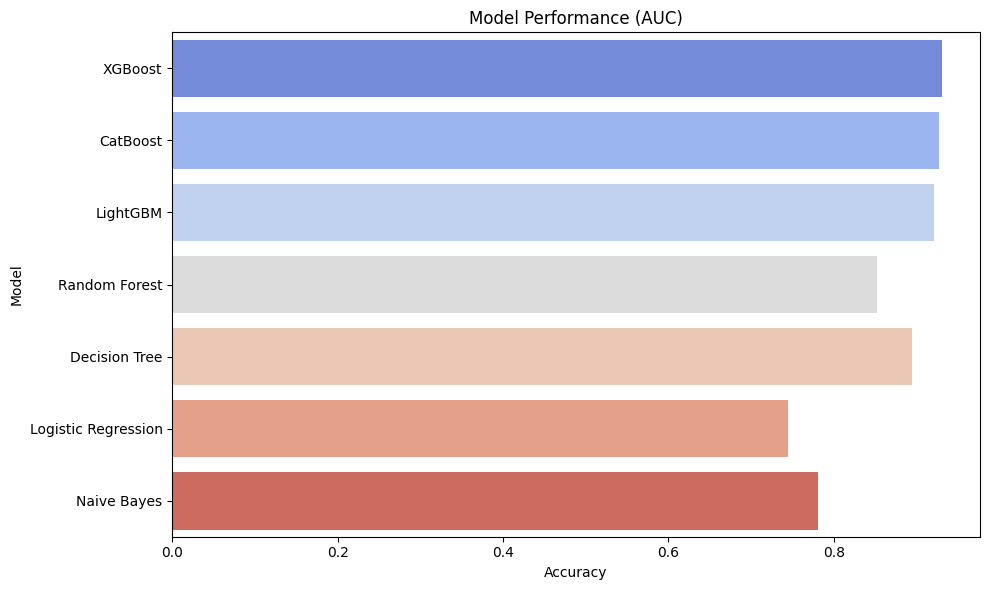

In [63]:
plt.figure(figsize=(10,6))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="coolwarm")
plt.title("Model Performance (AUC)")
plt.tight_layout()
plt.show()

In [64]:
best_model_name = results_df.iloc[0]['Model']
best_model_name

'XGBoost'

In [65]:
# === 11. Save best model and preprocessor ===
import joblib
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Get the best model based on AUC
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

# Re-fit the best model (to ensure it's trained with all data)
best_model.fit(X_train, y_train)

# Save the best model
joblib.dump(best_model, 'best_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# === 12. Prediction function for new samples ===
def predict_sample(new_data):
    """
    Predict using the saved model and scaler.
    
    Args:
        new_data (DataFrame): New data with same structure as training data
    
    Returns:
        tuple: (prediction, probability)
    """
    # Load model and scaler
    model = joblib.load('best_model.pkl')
    scaler = joblib.load('scaler.pkl')
    
    # Preprocess the new data
    # 1. Handle categoricals (JOB_* columns should already exist if using get_dummies)
    # 2. Ensure column order matches training
    new_data = new_data[X_train.columns]  # Reorder columns
    
    # Scale numerical features
    new_data_scaled = scaler.transform(new_data)
    
    # Predict
    prediction = model.predict(new_data_scaled)
    probability = model.predict_proba(new_data_scaled)[:, 1]
    
    return prediction, probability

# === 13. Example usage ===
# Create sample data (with all features including dummy columns)
sample_data = pd.DataFrame({
    'LOAN': [10000],
    'MORTDUE': [20000],
    'VALUE': [25000],
    'DEROG': [0],
    'DELINQ': [0],
    'CLAGE': [100],
    'NINQ': [1],
    'CLNO': [5],
    'DEBTINC': [35],
    'YOJ': [5],
    'JOB_Office': [0],
    'JOB_Other': [1],
    'JOB_ProfExe': [0],
    'JOB_Sales': [0],
    'JOB_Self': [0]
}, index=[0])

# Predict
prediction, probability = predict_sample(sample_data)
print(f"\nPrediction: {'BAD' if prediction[0] == 1 else 'GOOD'}")
print(f"Probability: {probability[0]:.2f}")

# === 14. Detailed evaluation of best model ===
print("\n=== Best Model Evaluation ===")
print(f"Model: {best_model_name}")

# Predict on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Print metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAUC-ROC:", roc_auc_score(y_test, y_proba))


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:45:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Prediction: BAD
Probability: 0.88

=== Best Model Evaluation ===
Model: XGBoost

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       954
           1       0.93      0.71      0.80       238

    accuracy                           0.93      1192
   macro avg       0.93      0.85      0.88      1192
weighted avg       0.93      0.93      0.93      1192


Confusion Matrix:
[[941  13]
 [ 70 168]]

AUC-ROC: 0.9572212532811868
